# AtLAST Predictions
Here, you can find another example of using this simulation tool for predictions. But now, in this scenario, we'll adjust all parameters to align with the AtLAST telescope design. AtLAST will have with a broad 2-degree field of view (FOV) and offers a 10" resolution at 150 GHz. This configuration provides a more comprehensive, high spatial dynamic range, ideal for observing phenomena such as the Sunyaev-Zeldovich effect in galaxy clusters.

In [27]:
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np

In [28]:
from maria import Simulation
from maria import mappers

In [29]:
pointing_center = (-10.0, 10.0)
pixel_size = 0.001
integration_time = 10.0 * 60.0

map_file = "../../../maps/SZ_pairs_c0001_s127_x-y-vz_p00_Jy.fits"  # Input files must be a fits file.

In [30]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u
from astropy.coordinates import SkyCoord

# - Input figure
cmap = "RdBu_r"
inputfile = map_file

hdu = fits.open(inputfile)
hdu[0].data = hdu[0].data
header = hdu[0].header
header["CDELT1"] = -1 * pixel_size  # degree
header["CDELT2"] = pixel_size  # degree
header["CTYPE1"] = "RA---SIN"
header["CUNIT1"] = "deg     "
header["CTYPE2"] = "DEC--SIN"
header["CUNIT2"] = "deg     "

header["CRVAL1"] = pointing_center[0]
header["CRVAL2"] = pointing_center[1]
wcs_input = WCS(header, naxis=2)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


### Fine-Tuning Simulation Parameters

To make predictions for AtLAST, several adjustments are required. Firstly, we need to change the pointing center. AtLAST is located near the APEX telescope in the southern hemisphere, so we set the pointing center to a Declination of -10. Additionally, we need to chance the atmospheric conditions. The defeault is set to mid-February at 6 am UT, which is an ideal time for observing with MUSTANG-2 on the GBT but not for AtLAST at Chajnantor. To achieve this, we modify the `start_time` key to August. This change also necessitates adjusting the Right Ascension (RA) of the pointing to ensure that the source remains above the horizon during the observation.

Furthermore, we overwrite the field of view to be 2 degrees and set the scan radius of the daisy scan to 1.3 degrees. We also adjust the detector bandwidth to 52 GHz with a total of 2000 detectors, and set a scan period of 120 seconds. 

Now, it's important to note that we haven't yet developed a mapper that can handle AtLAST's large FOV. Most of the contamination will likely be a common mode in the atmosphere, which needs proper Fourier filtering. This aspect is still a work in progress. Therefore, for the time being, we conduct noiseless observations by setting `atm_model = None`.

In [31]:
sim = Simulation(
    # Mandatory minimal weither settings
    # ---------------------
    array="AtLAST",  # Array type
    pointing="daisy",  # Scanning strategy
    site="APEX",  # Site
    # atm_model = 'single_layer',  # The atmospheric model, set to None if you want a noiseless observation.
    atm_model=None,  # The atmospheric model, set to None if you want a noiseless observation.
    # True sky input
    # ---------------------
    map_file=map_file,  # Input files must be a fits file.
    # map_file can also be set to None if are only interested in the noise
    map_center=pointing_center,  # RA & Dec in degree
    # Defeault Observational setup
    # ----------------------------
    integration_time=integration_time,  # seconds
    scan_center=pointing_center,  # degrees
    pointing_frame="ra_dec",  # frame
    scan_radius=1.3,  # Scanning radius in degrees
    field_of_view=2.0,
    dets={"f090": {"n": 2000, "band_center": 92.0, "band_width": 52.0}},
    start_time="2022-08-10T06:00:00",
    scan_period=100.0,
    sample_rate=150.0,
    # Additional inputs:
    # ----------------------
    weather_quantiles={
        "column_water_vapor": 0.1
    },  # Weather conditions specific for that site
    map_units="Jy/pixel",  # Kelvin Rayleigh Jeans (K, defeault) or Jy/pixel
    map_res=pixel_size,  # degree, overwrites header information
)

In [32]:
tod = sim.run()

### Visualizing the TOD Data

In this section, we present the same array and TOD visualizations as in the MUSTANG-2 case, but this time for AtLAST:

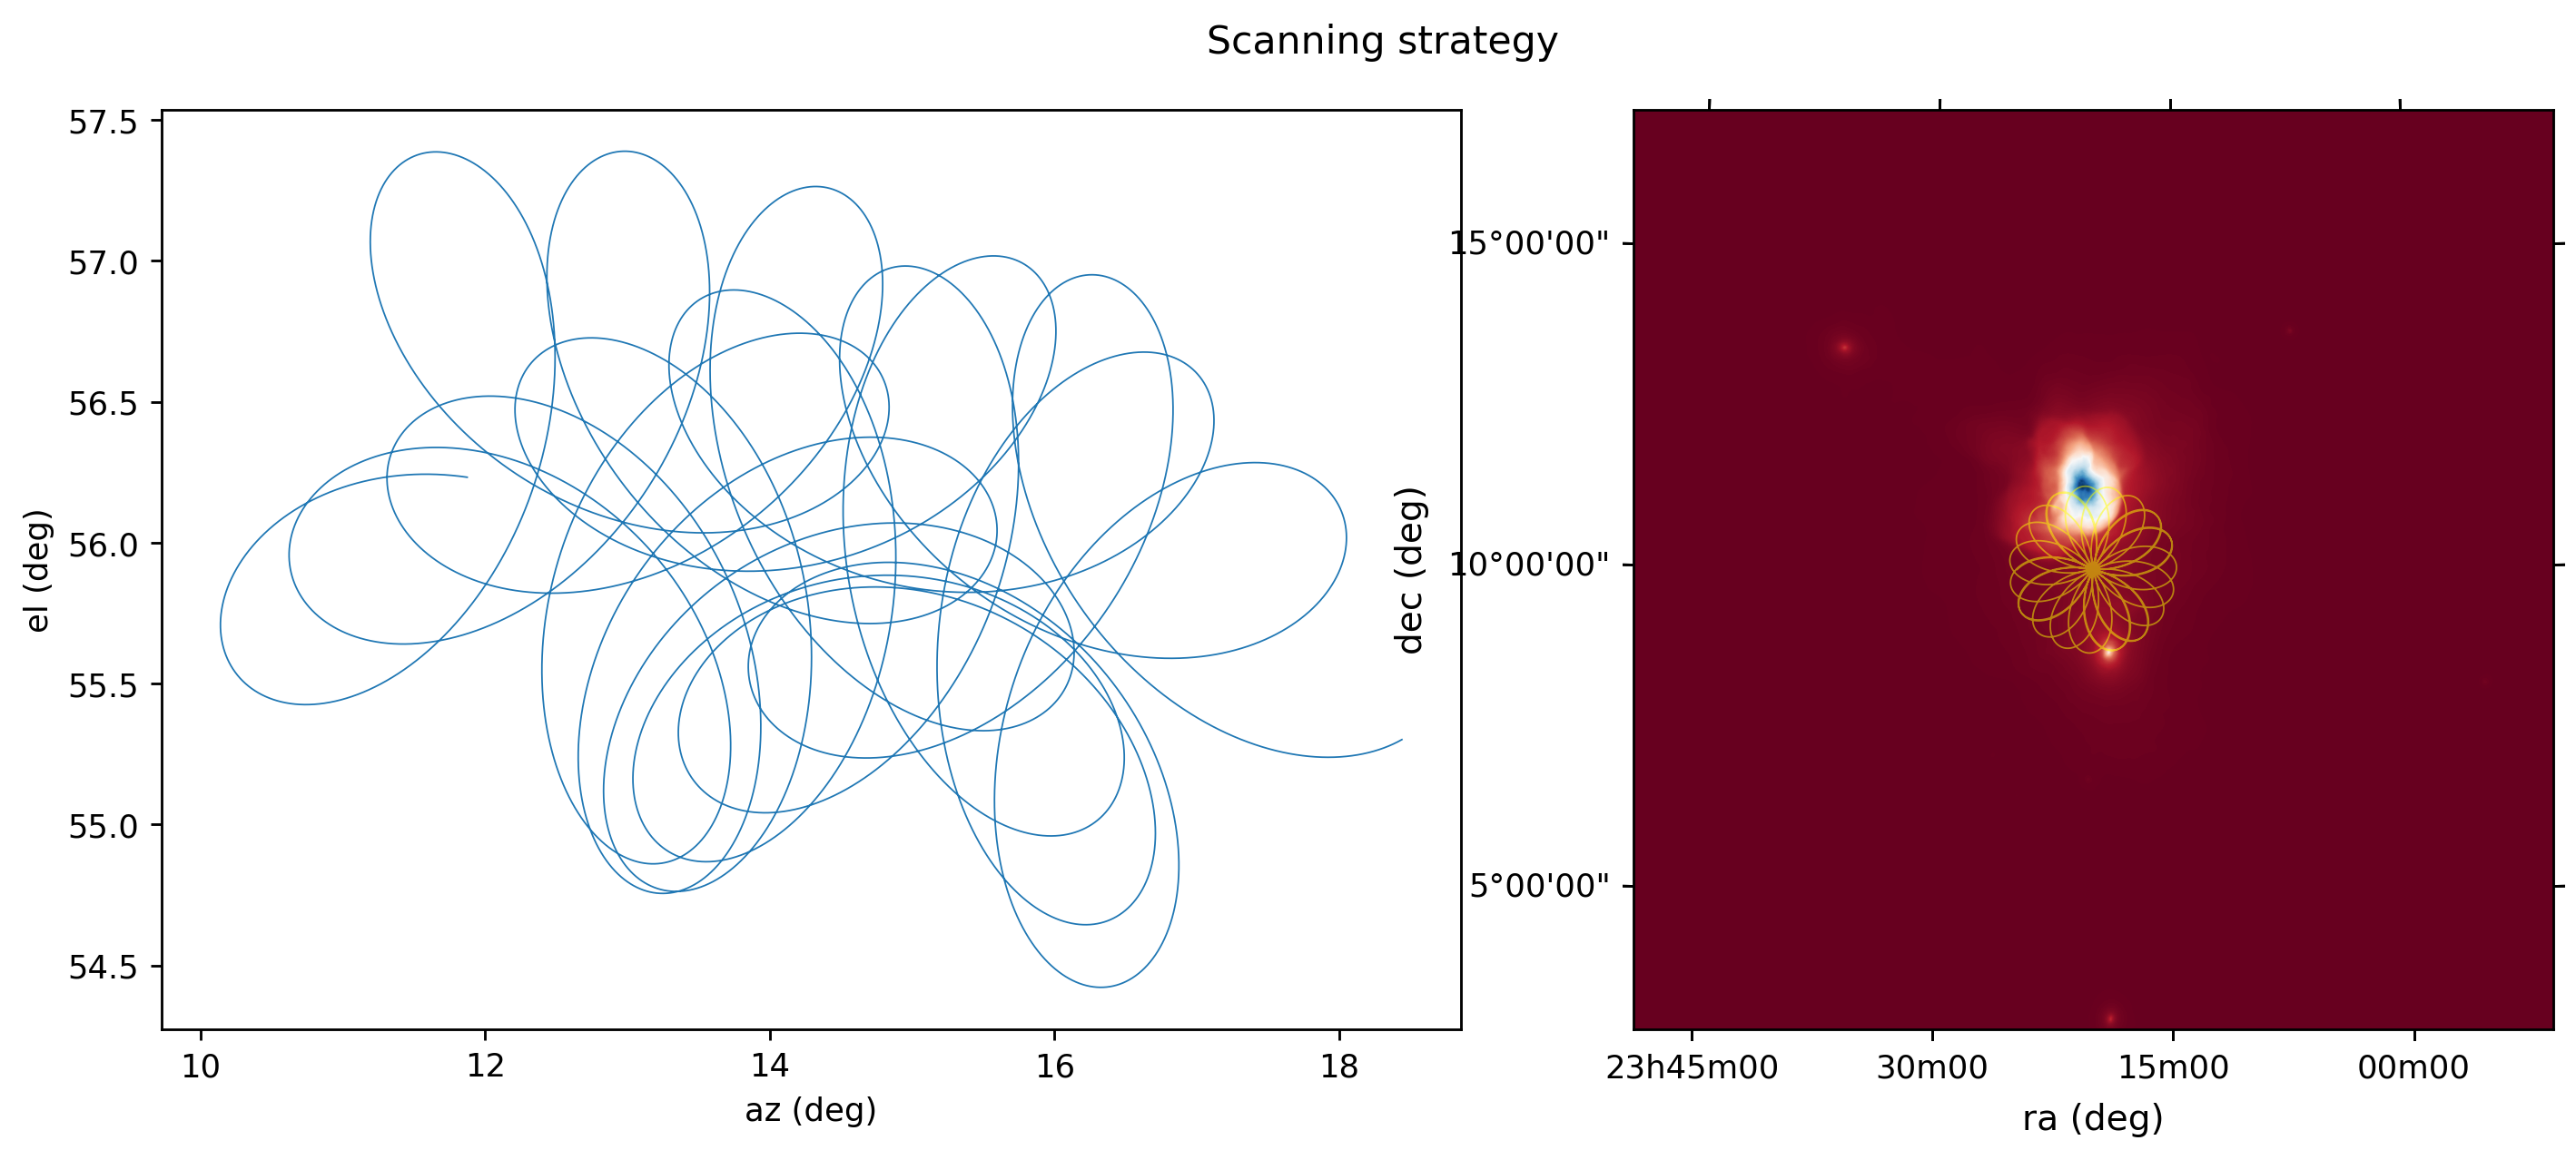

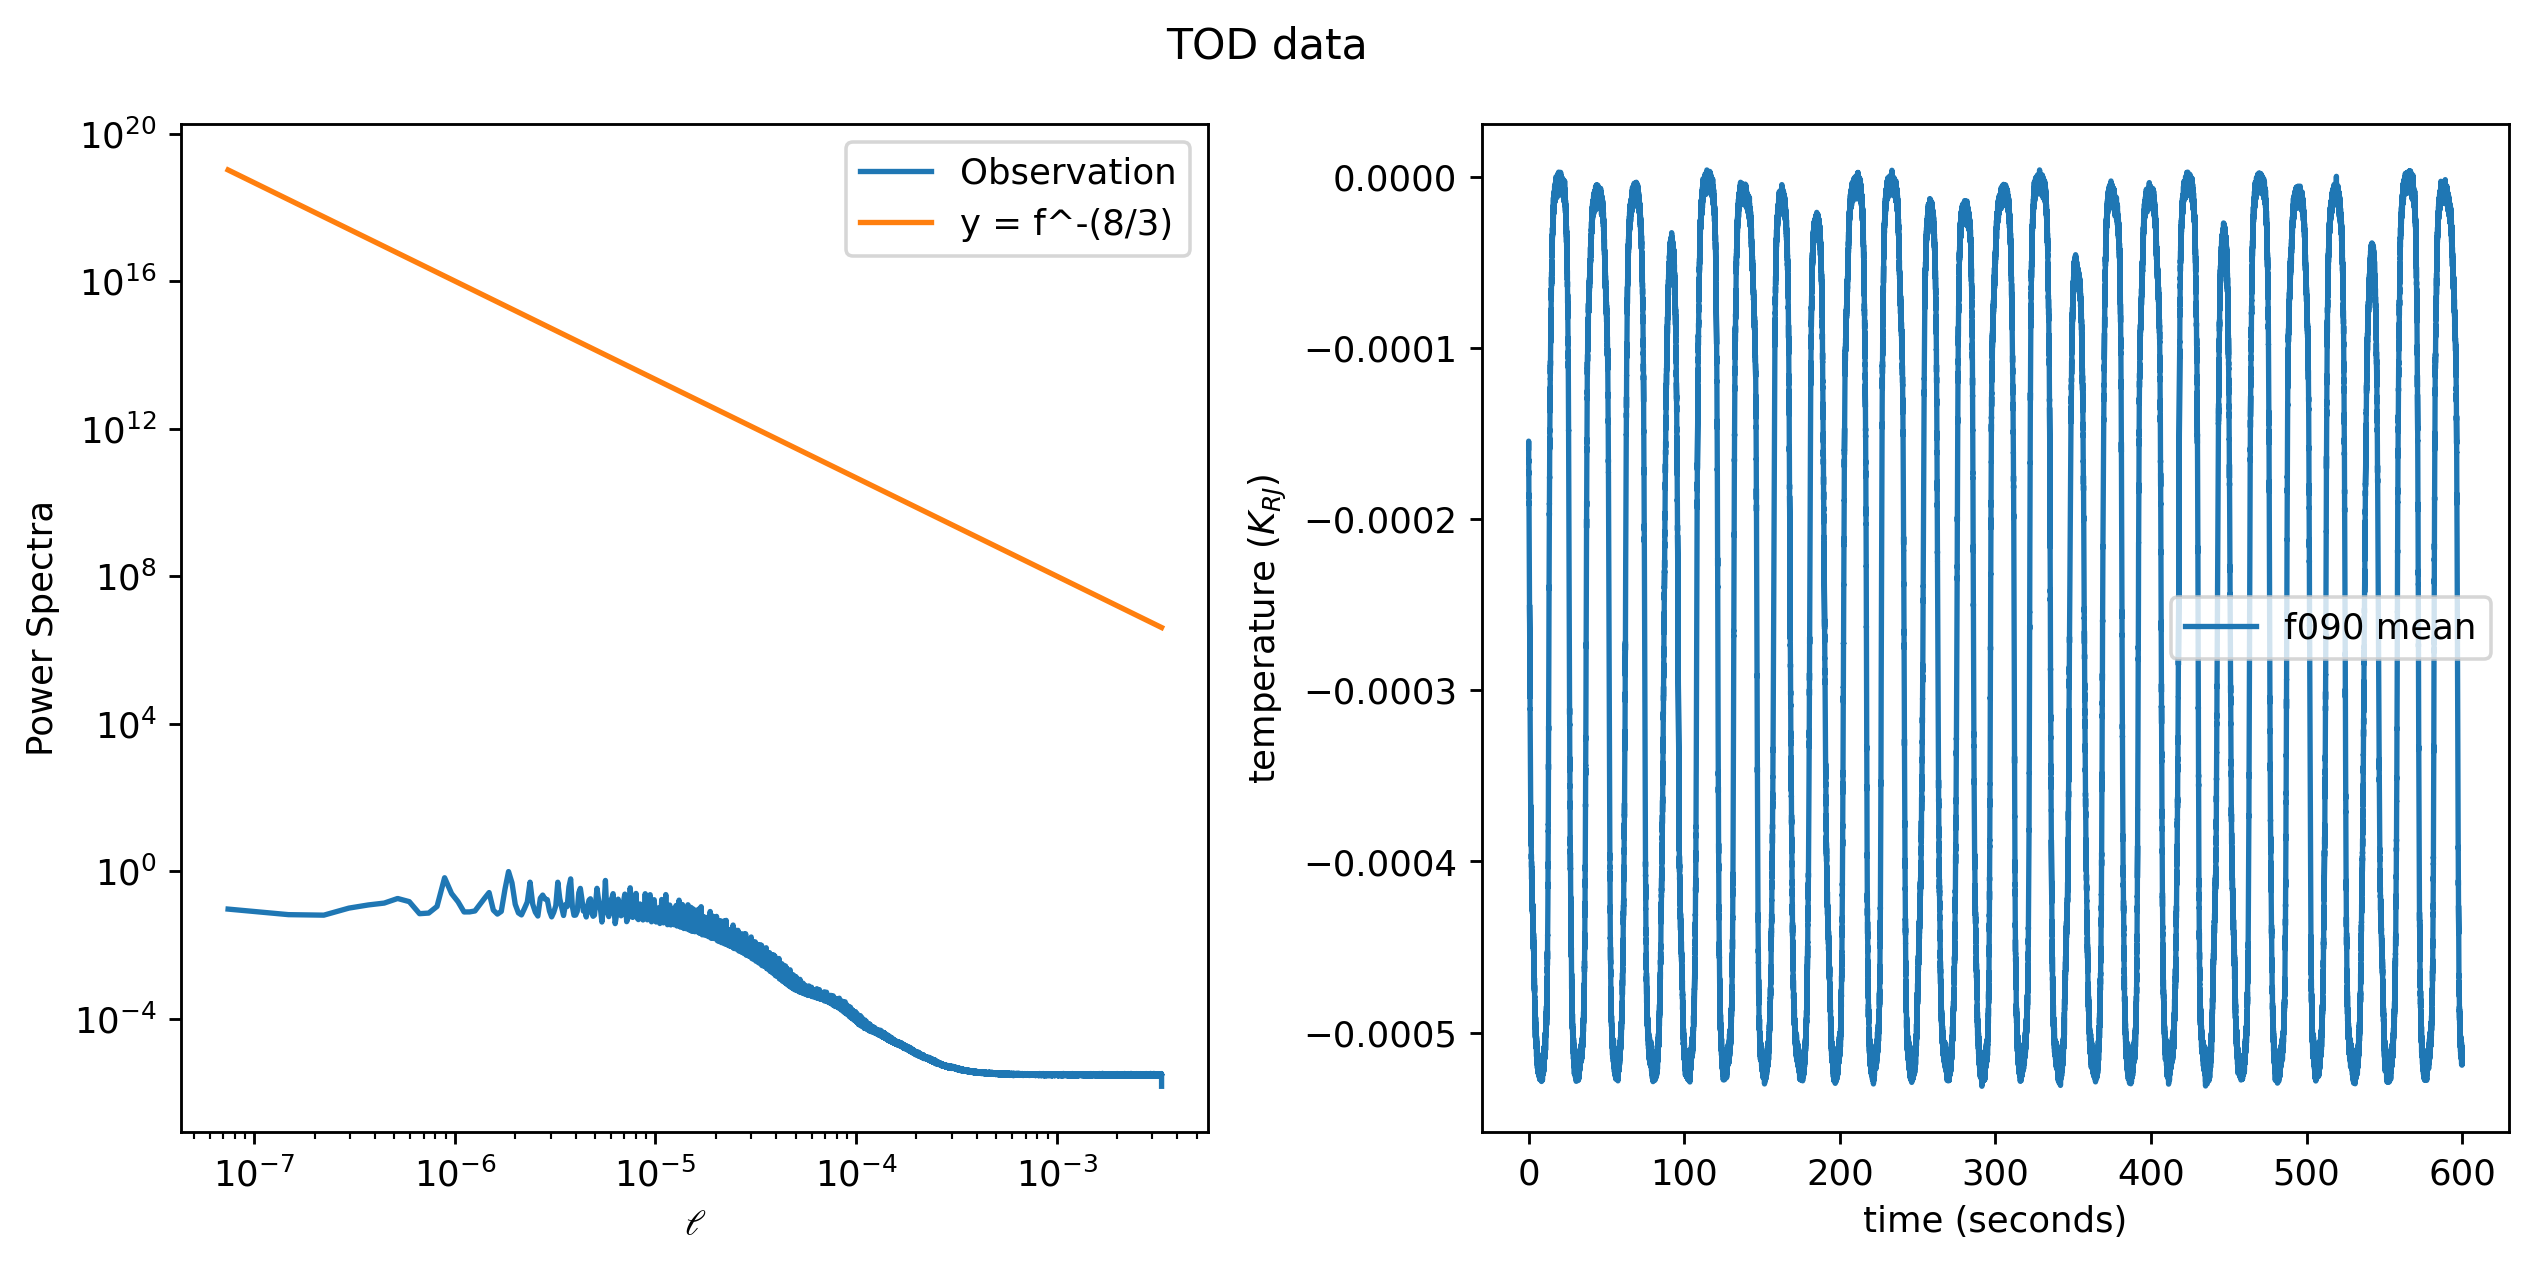

In [33]:
# visualize scanning patern
# -----------------------
fig = plt.figure(dpi=256, tight_layout=True)
fig.set_size_inches(12, 5, forward=True)
fig.suptitle("Scanning strategy")

# - Plot
ax = plt.subplot(
    1,
    2,
    1,
)

ax.plot(np.degrees(tod.az), np.degrees(tod.el), lw=5e-1)
ax.set_xlabel("az (deg)"), ax.set_ylabel("el (deg)")

ax = plt.subplot(1, 2, 2, projection=wcs_input)
im = ax.imshow(hdu[0].data, cmap=cmap)

ra, dec = ax.coords
ra.set_major_formatter("hh:mm:ss")
dec.set_major_formatter("dd:mm:ss")
ra.set_axislabel(r"RA [J2000]", size=11)
dec.set_axislabel(r"Dec [J2000]", size=11)
ra.set_separator(("h", "m"))

sky = SkyCoord(np.degrees(tod.ra) * u.deg, np.degrees(tod.dec) * u.deg)
pixel_sky = wcs_input.world_to_pixel(sky)
ax.plot(pixel_sky[0], pixel_sky[1], lw=5e-1, alpha=0.5, c="yellow")
ax.set_xlabel("ra (deg)"), ax.set_ylabel("dec (deg)")
plt.show()

# visualize powerspectrum
# -----------------------
f, ps = sp.signal.periodogram(tod.data, fs=tod.time[1] - tod.time[0], window="tukey")

fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=256, tight_layout=True)
fig.suptitle("TOD data")
axes[0].plot(f[1:], ps.mean(axis=0)[1:], label="Observation")
axes[0].plot(f[1:], f[1:] ** (-8 / 3), label="y = f^-(8/3)")
axes[0].set_xlabel(r"$\mathscr{l}$"), axes[0].set_ylabel("Power Spectra")
axes[0].loglog(), axes[0].legend()

for uib, uband in enumerate(np.unique(tod.dets.band)):
    band_mask = tod.dets.band == uband
    band_mean = tod.data[band_mask].mean(axis=0)
    axes[1].plot(tod.time - tod.time[0], band_mean, label=f"{uband} mean")

axes[1].set_xlabel("time (seconds)"), axes[1].set_ylabel(r"temperature ($K_{RJ}$)")
axes[1].legend()

plt.show()

## Map-Making

As previously mentioned, we must disable Fourier filtering. Additionally, we have adjusted the height and width of the map to match the realistic AtLAST field of view, which spans several degrees.

In [34]:
mapper = mappers.BinMapper(
    map_height=np.radians(4.5),
    map_width=np.radians(4.5),
    map_res=np.radians(4 * pixel_size),
    map_filter=False,
    n_modes_to_remove=1,
)
mapper.add_tods(tod)
mapper.run()

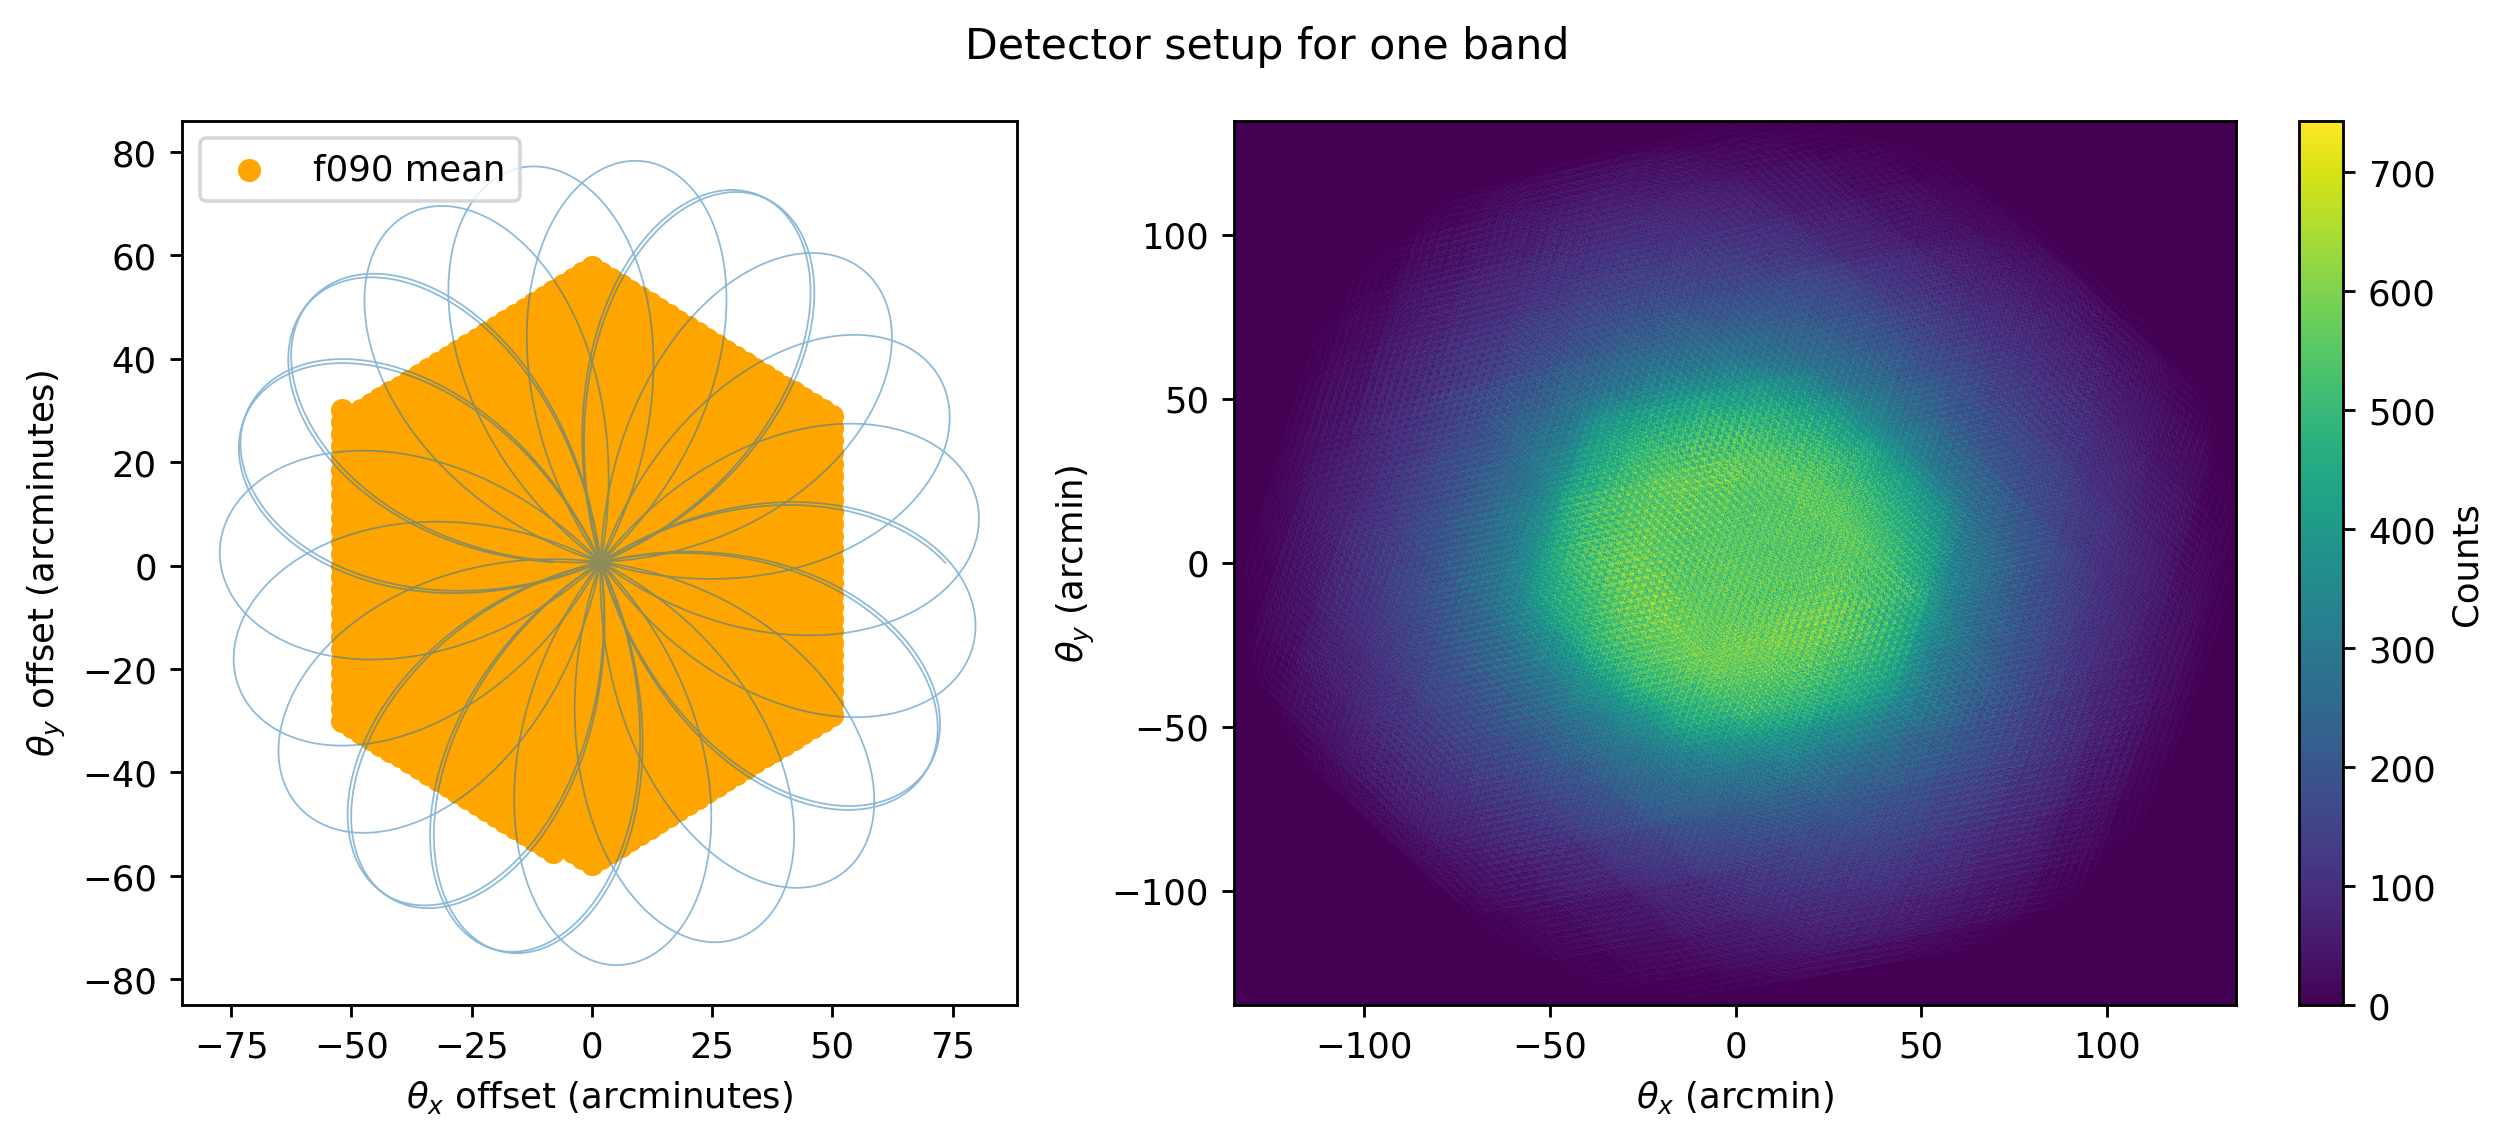

In [35]:
fig, axes = plt.subplots(
    1,
    2,
    figsize=(10, 4.5),
    dpi=256,
    tight_layout=True,
    gridspec_kw={"width_ratios": [1, 1.5]},
)
fig.suptitle("Detector setup for one band")

for uband in sim.array.ubands:
    band_mask = sim.array.dets.band == uband

    axes[0].plot(
        60 * np.degrees(tod.ra - tod.ra.mean()),
        60 * np.degrees(tod.dec - tod.dec.mean()),
        lw=5e-1,
        alpha=0.5,
    )
    axes[0].scatter(
        60 * np.degrees(sim.array.offset_x[band_mask]),
        60 * np.degrees(sim.array.offset_y[band_mask]),
        label=f"{uband} mean",
        lw=5e-1,
        c="orange",
    )
    break
axes[0].set_xlabel(r"$\theta_x$ offset (arcminutes)"), axes[0].set_ylabel(
    r"$\theta_y$ offset (arcminutes)"
)
axes[0].legend()

xs, ys = np.meshgrid(
    60 * np.rad2deg((mapper.x_bins[1:] + mapper.x_bins[:-1]) / 2),
    60 * np.rad2deg((mapper.y_bins[1:] + mapper.y_bins[:-1]) / 2),
)

im = axes[1].pcolormesh(
    xs,
    ys,
    mapper.map_cnts[tod.dets.band[0]],
    label="Photon counts in band " + tod.dets.band[0],
)

axes[1].set_xlabel(r"$\theta_x$ (arcmin)"), axes[1].set_ylabel(r"$\theta_y$ (arcmin)")
cbar = plt.colorbar(im, ax=axes[1])
cbar.set_label("Counts")
plt.show()

## Save & Visualize

In [36]:
mapper.save_maps("/tmp/test2.fits")

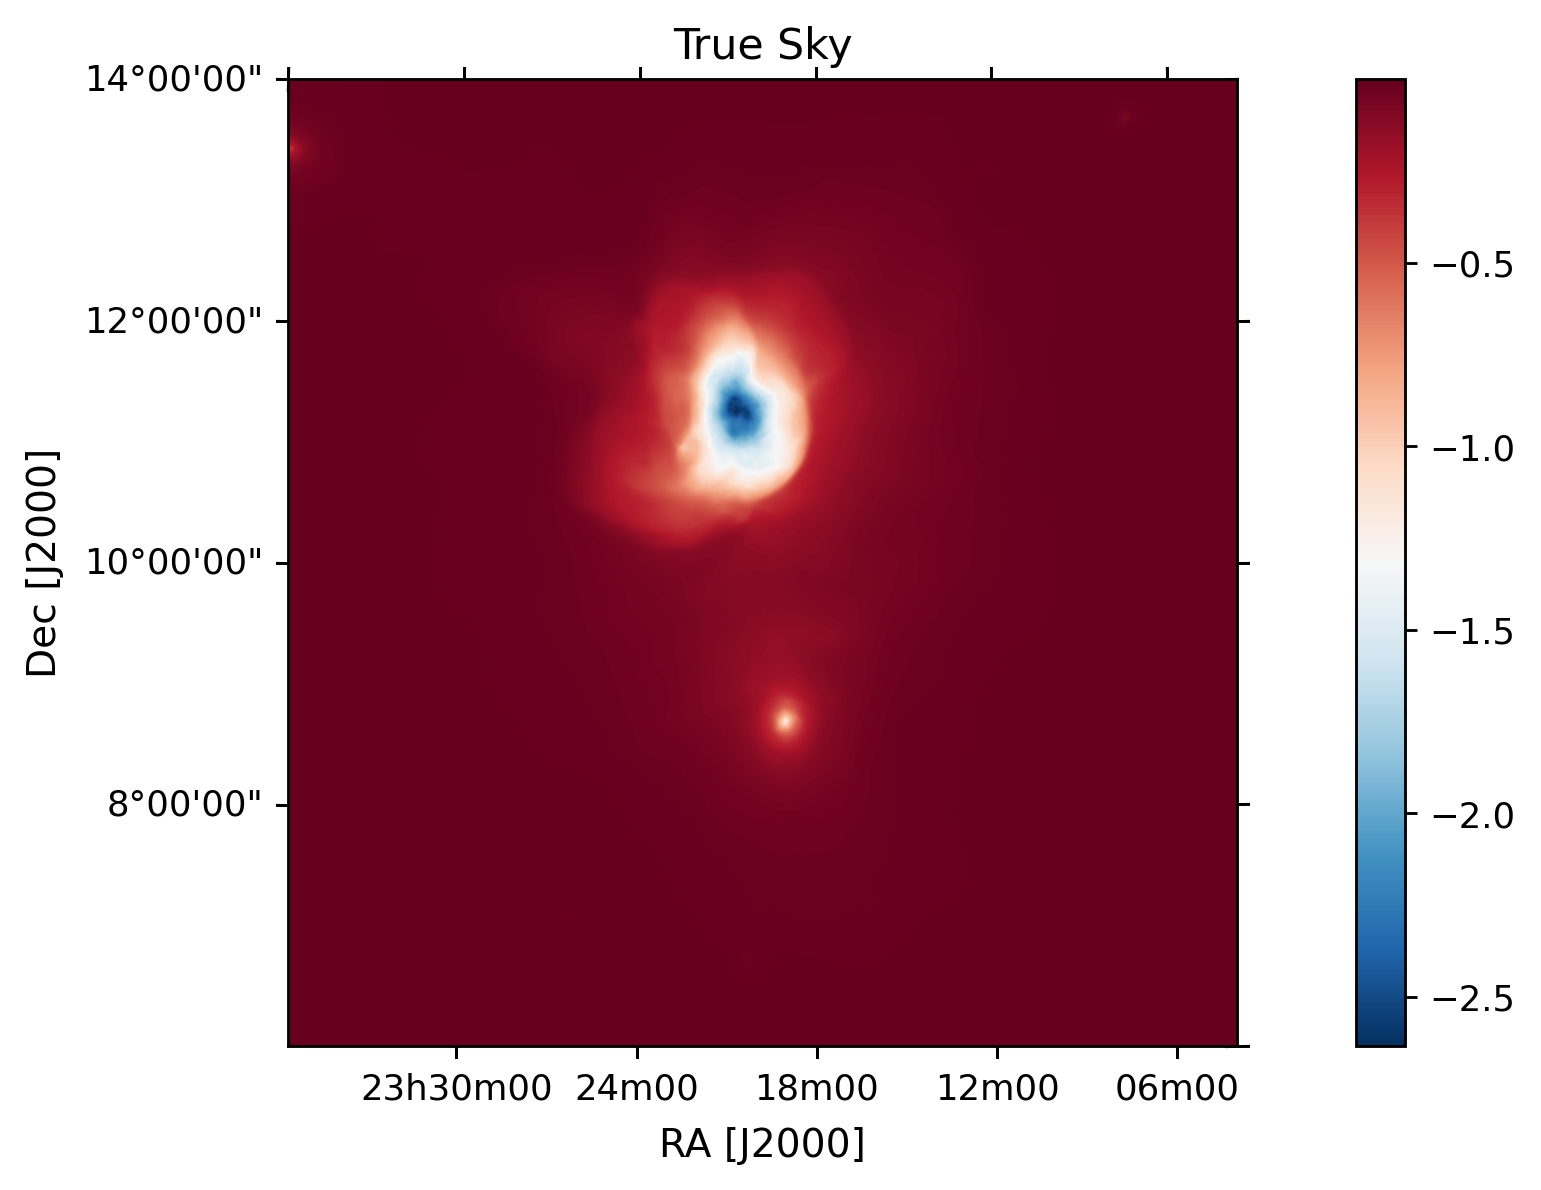

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


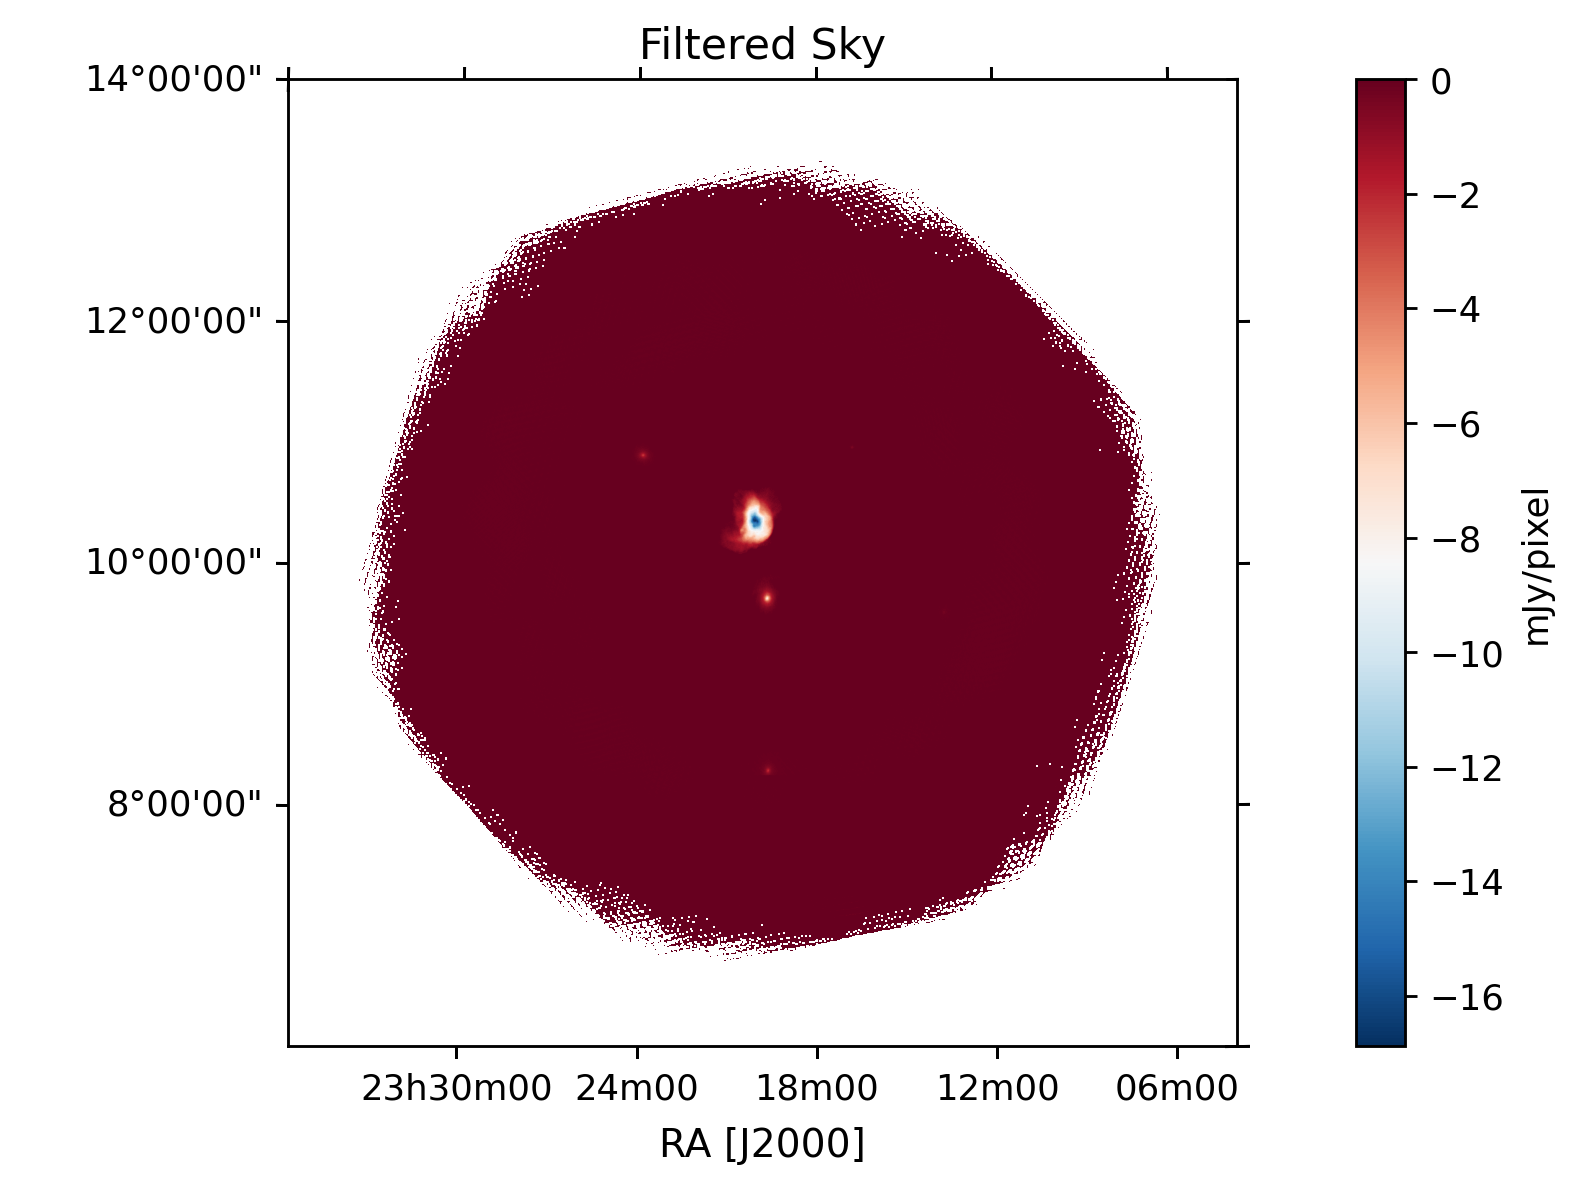

In [37]:
sky_l = SkyCoord((pointing_center[0] - 4) * u.deg, (pointing_center[1] - 4) * u.deg)
sky_u = SkyCoord((pointing_center[0] + 4) * u.deg, (pointing_center[1] + 4) * u.deg)

fig = plt.figure(dpi=256, tight_layout=False)
fig.set_size_inches(12, 5, forward=True)

# - Plot
ax = plt.subplot(1, 1, 1, projection=wcs_input)
ax.set_title("True Sky")
im = ax.imshow(hdu[0].data * 1e3, cmap=cmap)
cbar = plt.colorbar(im, ax=ax, shrink=1.0)

ra, dec = ax.coords
ra.set_major_formatter("hh:mm:ss")
dec.set_major_formatter("dd:mm:ss")
ra.set_axislabel(r"RA [J2000]", size=11)
dec.set_axislabel(r"Dec [J2000]", size=11)
ra.set_separator(("h", "m"))

pixel_sky_l = wcs_input.world_to_pixel(sky_l)
pixel_sky_u = wcs_input.world_to_pixel(sky_u)
ax.axis(
    xmax=pixel_sky_l[0], ymin=pixel_sky_l[1], xmin=pixel_sky_u[0], ymax=pixel_sky_u[1]
)
plt.show()

# - Mock observation
outputfile = "/tmp/test2.fits"

hdu_out = fits.open(outputfile)
wcs_output = WCS(hdu_out[0].header, naxis=2)


fig = plt.figure(dpi=256, tight_layout=False)
fig.set_size_inches(12, 5, forward=True)

# - Plot
ax = plt.subplot(1, 1, 1, projection=wcs_output)
ax.set_title("Filtered Sky")
im = ax.imshow(hdu_out[0].data[0] * 1e3, cmap=cmap, vmax=0)
cbar = plt.colorbar(im, ax=ax, shrink=1.0)
cbar.set_label("mJy/pixel")

ra, dec = ax.coords
ra.set_major_formatter("hh:mm:ss")
dec.set_major_formatter("dd:mm:ss")
ra.set_axislabel(r"RA [J2000]", size=11)
dec.set_axislabel(r" ", size=11)
ra.set_separator(("h", "m"))

pixel_sky_l = wcs_output.world_to_pixel(sky_l)
pixel_sky_u = wcs_output.world_to_pixel(sky_u)
ax.axis(
    xmax=pixel_sky_l[0], ymin=pixel_sky_l[1], xmin=pixel_sky_u[0], ymax=pixel_sky_u[1]
)

plt.show()

## Fidelity Test

To gain insight into how the scanning strategy influences the quality of the observation, we've created a simple fidelity map. This map illustrates how modifying the scanning strategy impacts the recovery of your science. In particular, the sampling rate and scanning period have a significant influence on the image's fidelity. We are continually working on optimizing the scanning strategy for AtLAST, but you are welcome to experiment with these values yourself to observe their effect on the fidelity map.

In [38]:
from reproject import reproject_interp

sim_projected, footprint = reproject_interp(
    (hdu[0].data, wcs_input), wcs_output, shape_out=hdu_out[0].data[0].shape
)

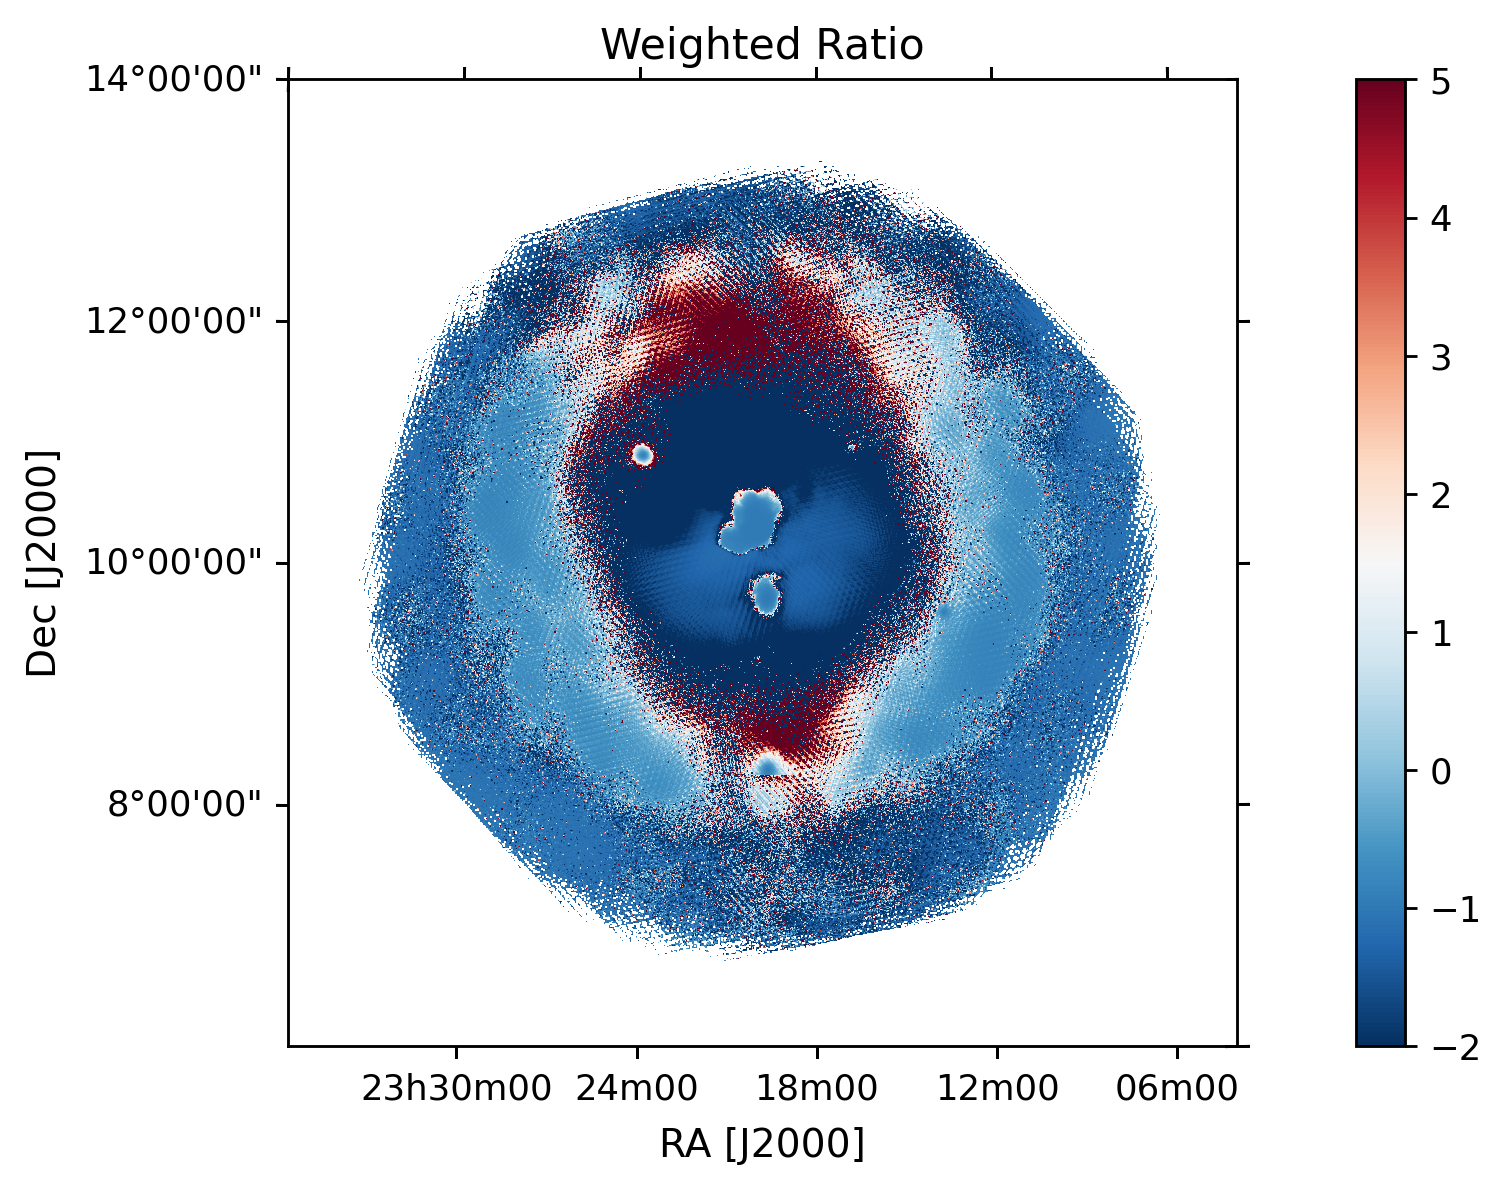

In [39]:
fig = plt.figure(dpi=256, tight_layout=False)
fig.set_size_inches(12, 5, forward=True)

# - Plot
ax = plt.subplot(1, 1, 1, projection=wcs_output)
ax.set_title("Weighted Ratio")
im = ax.imshow((sim_projected / hdu_out[0].data[0]) - 1, cmap=cmap, vmin=-2, vmax=5)
cbar = plt.colorbar(im, ax=ax, shrink=1.0)
# cbar.set_label('mock/sim - 1')

ra, dec = ax.coords
ra.set_major_formatter("hh:mm:ss")
dec.set_major_formatter("dd:mm:ss")
ra.set_axislabel(r"RA [J2000]", size=11)
dec.set_axislabel(r"Dec [J2000]", size=11)
ra.set_separator(("h", "m"))

pixel_sky_l = wcs_output.world_to_pixel(sky_l)
pixel_sky_u = wcs_output.world_to_pixel(sky_u)
ax.axis(
    xmax=pixel_sky_l[0], ymin=pixel_sky_l[1], xmin=pixel_sky_u[0], ymax=pixel_sky_u[1]
)

plt.show()